In [163]:
import pandas as pd
import numpy as np
import math
import ast
from datetime import datetime
from plotnine import *
import patchworklib as pw
from IPython.display import display
from mizani.formatters import percent_format
from pathlib import Path
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.inspection import (
    partial_dependence,
    permutation_importance,
    PartialDependenceDisplay,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

from utils.py_helper_functions import *

In [4]:
# read raw data files
data_dir = 'raw_data'
milanQ2 = pd.read_csv(Path(data_dir, 'Milan2024Q2.csv'), index_col = 0)
milanQ3 = pd.read_csv(Path(data_dir, 'Milan2024Q3.csv'), index_col = 0)
florenceQ2 = pd.read_csv(Path(data_dir, 'Florence2024Q2.csv'), index_col = 0)

In [5]:
# keep only such columns that are present in all dataframes
# for these dataframes, this actually does not drop anything
# but this may not be the case for other data
milanQ2.drop([col for col in milanQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
milanQ3.drop([col for col in milanQ3 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
florenceQ2.drop([col for col in florenceQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)

In [6]:
def distance_to_center(lat, lon, center_lat, center_lon):
    # radius of Earth in kilometers
    R = 6371.0
    
    # convert degrees to radians
    lat1, lon1 = math.radians(center_lat), math.radians(center_lon)
    lat2, lon2 = math.radians(lat), math.radians(lon)
    
    # differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # distance in kilometers
    distance = R * c
    
    return distance

In [7]:
def clean_df(df, center_lat, center_lon):
    df = df.copy() #not inplace

    # number of days the host is registered (no missing)
    df['n_host_since'] = (pd.to_datetime(df['last_scraped'], format = '%Y-%m-%d') - pd.to_datetime(df['host_since'], format = '%Y-%m-%d')).dt.days

    # host location Italy or Other, NAs imputed with missing category
    df['f_host_location'] = df['host_location'].apply(
        lambda x: 'Italy' if isinstance(x, str) and 'italy' in x.lower() else ('Missing' if pd.isna(x) else 'Other')).astype('category')

    # simple categorical, added Missing category for NAs
    df['f_host_response_time'] = df['host_response_time'].fillna('Missing').astype('category')

    # converted to numeric scale, imputed 0s for missing values (based on Ch16 case study code)
    df['p_host_response_rate'] = df.host_response_rate.fillna('0%').apply(lambda x: int(x.strip('%')))

    # converted to numeric scale, imputed 0s for missing values (based on Ch16 case study code)
    df['p_host_acceptance_rate'] = df.host_acceptance_rate.fillna('0%').apply(lambda x: int(x.strip('%')))

    # converted to binary, no missing
    df['d_host_is_superhost'] = df.host_is_superhost.apply(lambda x: 1 if x == 't' else 0)

    # added dummies for every possible host verification type (only three in practice)
    df = df.join(df['host_verifications'].apply(ast.literal_eval).apply(lambda x: pd.Series(1, index=x)).fillna(0).astype(int).add_prefix('d_hostverif_'))

    # converted to binary, no missing
    df['d_host_has_profile_pic'] = df.host_has_profile_pic.apply(lambda x: 1 if x == 't' else 0)

    # converted to binary, no missing
    df['d_host_identity_verified'] = df.host_identity_verified.apply(lambda x: 1 if x == 't' else 0)

    # I figured that I should not use neighbourhood data in my models, as in the case of Florence live data, I will have completely different values
    # So instead, I will use distance to center (calculated by me).
    #df['f_neighbourhood'] = df.neighbourhood_cleansed.astype('category')

    # Filtering to a sensible set of property types
    df = df.loc[lambda x: x['property_type'].isin(['Entire rental unit', 'Entire condo', 'Private room in rental unit', 'Private room in condo',
                                          'Entire loft', 'Entire home', 'Private room in loft', 'Private room in home'])]

    # Setting values to categories, no missing
    df['f_property_type'] = df.property_type.astype('category')

    # Setting values to categories, no missing
    df['f_room_type'] = df.room_type.astype('category')

    # Not interested in extremely big listings, filtering to max. 8 guests
    df = df[df['accommodates'] <= 8]
    df['n_accomodates'] = df.accommodates

    # Creating bathroom categories (1, 2 and 2+)
    df['f_bathrooms'] = df.bathrooms.fillna(1).apply(lambda x: '0' if x < 1 else ('1' if (x >= 1 and x < 2) else ('2' if (x >= 2 and x < 3) else '2+'))).astype('category')

    # Imputing the number of bedrooms with the median
    df['n_bedrooms'] = df.bedrooms.fillna(np.median(df['bedrooms'].dropna()))

    # Imputing the number of beds with the number of possible guests
    df['n_beds'] = df.beds.fillna(df['accommodates'])

    # Adding a dummy for all possible amenities (will remove many later)
    df = df.join(df['amenities'].apply(lambda x: pd.Series(1, index=[amen.replace(' ', '_').replace('-', '_').lower() for amen in ast.literal_eval(x)])).add_prefix('d_amenities_').fillna(0).astype(int))

    # Dropping observations where no price (target), converting it to float
    df = df[df['price'].notna()]
    df['eur_price'] = df.price.apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)

    # Interested in AirBnBs for short-term tourism: minimum nights should not be more than a week
    df = df[df['minimum_nights'] <= 7]

    # Categorizing the number of reviews: 0, 1-10, 11-30, 30+
    fnor = pd.cut(df['number_of_reviews'].to_list(),
       pd.IntervalIndex.from_tuples([(0, 1), (1, 11), (11, 31), (31, max(df.number_of_reviews)+1)], closed="left"),
       labels=['0', '1-10', '11-30', '30+'])
    fnor = fnor.rename_categories([0, 1, 2, 3])
    df['f_number_of_reviews'] = fnor

    # Calculating number of days since the first review
    df["n_days_since_first_rev"] = (
    df.last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        - df.first_review.fillna("1950-01-01").apply(
            lambda x: datetime.strptime(x, "%Y-%m-%d")
        )).dt.days
    df["n_days_since_first_rev"] = np.where(df.first_review.isnull(), np.nan, df.n_days_since_first_rev)

    # adding prefix, will deal with missing later
    df['n_review_scores_rating'] = df.review_scores_rating

    # converting to binary, no missing
    df['d_instant_bookable'] = df.instant_bookable.apply(lambda x: 1 if x == 't' else 0)

    # Categorizing host listings count: 1, 2-10, 10+
    hlc = pd.cut(df['calculated_host_listings_count'].to_list(),
       pd.IntervalIndex.from_tuples([(0, 2), (2, 11), (11, max(df.calculated_host_listings_count)+1)], closed="left"),
       labels=['1', '2-10', '10+'])
    hlc = hlc.rename_categories([0, 1, 2])
    df['f_host_listings_count'] = hlc

    # Adding prefix, will deal with missing later
    df['n_reviews_per_month'] = df.reviews_per_month

    # calculating distance to city center
    df['n_distance_to_center'] = df.apply(lambda row: distance_to_center(row['latitude'], row['longitude'], center_lat, center_lon), axis=1)

    # filtering to columns with prefixes
    df = df.filter(regex="^d_.*|^n_.*|^f_.*|^p_.*|^eur_.*",)

    # creating flags for variables that had many missing values, and imputing with median
    df = df.assign(
        flag_n_days_since_first_rev = np.multiply(df.n_days_since_first_rev.isna(), 1),
        n_days_since_first_rev = df.n_days_since_first_rev.fillna(np.median(df.n_days_since_first_rev.dropna())),
        flag_n_review_scores_rating = np.multiply(df.n_review_scores_rating.isna(), 1),
        n_review_scores_rating = df.n_review_scores_rating.fillna(
            np.median(df.n_review_scores_rating.dropna())
        ),
        flag_n_reviews_per_month = np.multiply(df.n_reviews_per_month.isna(), 1),
        n_reviews_per_month = df.n_reviews_per_month.fillna(
            np.median(df.n_reviews_per_month.dropna())
        )
    )

    return df

In [9]:
milan_lat = 45.464664
milan_lon = 9.188540
florence_lat = 43.769562
florence_lon  = 11.255814

In [10]:
milanQ2 = clean_df(milanQ2, milan_lat, milan_lon)

In [11]:
# keep only such amenities in our source data that are present at at least 25% of the listings
milanQ2.drop([col for col in milanQ2.columns if ('d_amenities' in col and milanQ2[col].sum() < milanQ2.shape[0]*0.25)], inplace = True, axis = 1)

In [17]:
milanQ3 = clean_df(milanQ3, milan_lat, milan_lon)

In [18]:
florenceQ2 = clean_df(florenceQ2, florence_lat, florence_lon)

In [19]:
# filter out such host_verifs and amenities that are not present in all tables
# the other cols are common as we have created them
milanQ2.drop([col for col in milanQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
milanQ3.drop([col for col in milanQ3 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
florenceQ2.drop([col for col in florenceQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)

In [20]:
def add_poly_vars(df):
    df = df.copy()
    numeric_cols = [col for col in df if col[0:2] == 'n_']
    for c in numeric_cols:
        df[f'sq_{c}'] = np.power(df[c], 2)
        df[f'cu_{c}'] = np.power(df[c], 3)
    return df

In [21]:
milanQ2 = add_poly_vars(milanQ2)
milanQ3 = add_poly_vars(milanQ3)
florenceQ2 = add_poly_vars(florenceQ2)

In [22]:
milanQ2[[col for col in milanQ2 if col[0:2] == 'n_']].describe().T

,count,mean,std,min,25%,50%,75%,max
n_host_since,20730.0,2541.313362,1336.679403,3.000000,1438.000000,2930.000000,3606.000000,5576.000000
n_accomodates,20730.0,3.224940,1.367177,1.000000,2.000000,3.000000,4.000000,8.000000
n_bedrooms,20730.0,1.178244,0.580381,0.000000,1.000000,1.000000,1.000000,5.000000
n_beds,20730.0,1.603232,1.122176,0.000000,1.000000,1.000000,2.000000,17.000000
n_days_since_first_rev,20730.0,864.561119,967.593807,0.000000,251.000000,480.000000,989.000000,5178.000000
n_review_scores_rating,20730.0,4.731977,0.387399,0.000000,4.670000,4.840000,4.960000,5.000000
n_reviews_per_month,20730.0,1.690186,1.907503,0.010000,0.470000,1.010000,2.140000,27.690000
n_distance_to_center,20730.0,3.003237,1.529555,0.037974,1.885192,2.823209,3.841611,9.679887


In [23]:
milanQ2.eur_price.describe(percentiles=[0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.99])

count    20730.000000
mean       179.544621
std        967.429763
min         12.000000
1%          42.000000
5%          56.000000
25%         83.000000
50%        110.000000
75%        163.000000
95%        394.000000
99%       1000.000000
max      90000.000000
Name: eur_price, dtype: float64

In [24]:
# prices above 1000 EUR are clearly erronous - and we should not try to predict errors
milanQ2 = milanQ2[milanQ2['eur_price'] <= 1000]

In [25]:
data_train, data_holdout = train_test_split(milanQ2, train_size=0.7, random_state=42)

In [113]:
basic_vars = ('f_property_type', 'f_room_type', 'n_accomodates', 'f_bathrooms', 'n_bedrooms', 'n_beds', 'n_distance_to_center', 'd_instant_bookable')
host_vars = ('n_host_since', 'f_host_location', 'f_host_response_time', 'p_host_response_rate', 'p_host_acceptance_rate', 'd_host_is_superhost',
             'd_hostverif_email', 'd_hostverif_phone', 'd_hostverif_work_email', 'd_host_has_profile_pic', 'd_host_identity_verified',
             'f_host_listings_count')
review_vars = ('f_number_of_reviews', 'n_days_since_first_rev', 'n_review_scores_rating', 'n_reviews_per_month', 'flag_n_days_since_first_rev',
              'flag_n_review_scores_rating', 'flag_n_reviews_per_month')
amenities = tuple([col for col in data_train if 'd_amenities_' in col])
poly_vars = tuple([col for col in data_train if col[0:2] in ['sq', 'cu']])

In [115]:
predictors_ml = basic_vars + host_vars + review_vars + amenities

In [117]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14405 entries, 1178032757057287046 to 1055642404753527934
Data columns (total 87 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   n_host_since                            14405 non-null  int64   
 1   f_host_location                         14405 non-null  category
 2   f_host_response_time                    14405 non-null  category
 3   p_host_response_rate                    14405 non-null  int64   
 4   p_host_acceptance_rate                  14405 non-null  int64   
 5   d_host_is_superhost                     14405 non-null  int64   
 6   d_hostverif_email                       14405 non-null  int32   
 7   d_hostverif_phone                       14405 non-null  int32   
 8   d_hostverif_work_email                  14405 non-null  int32   
 9   d_host_has_profile_pic                  14405 non-null  int64   
 10  d_host_identity_ver

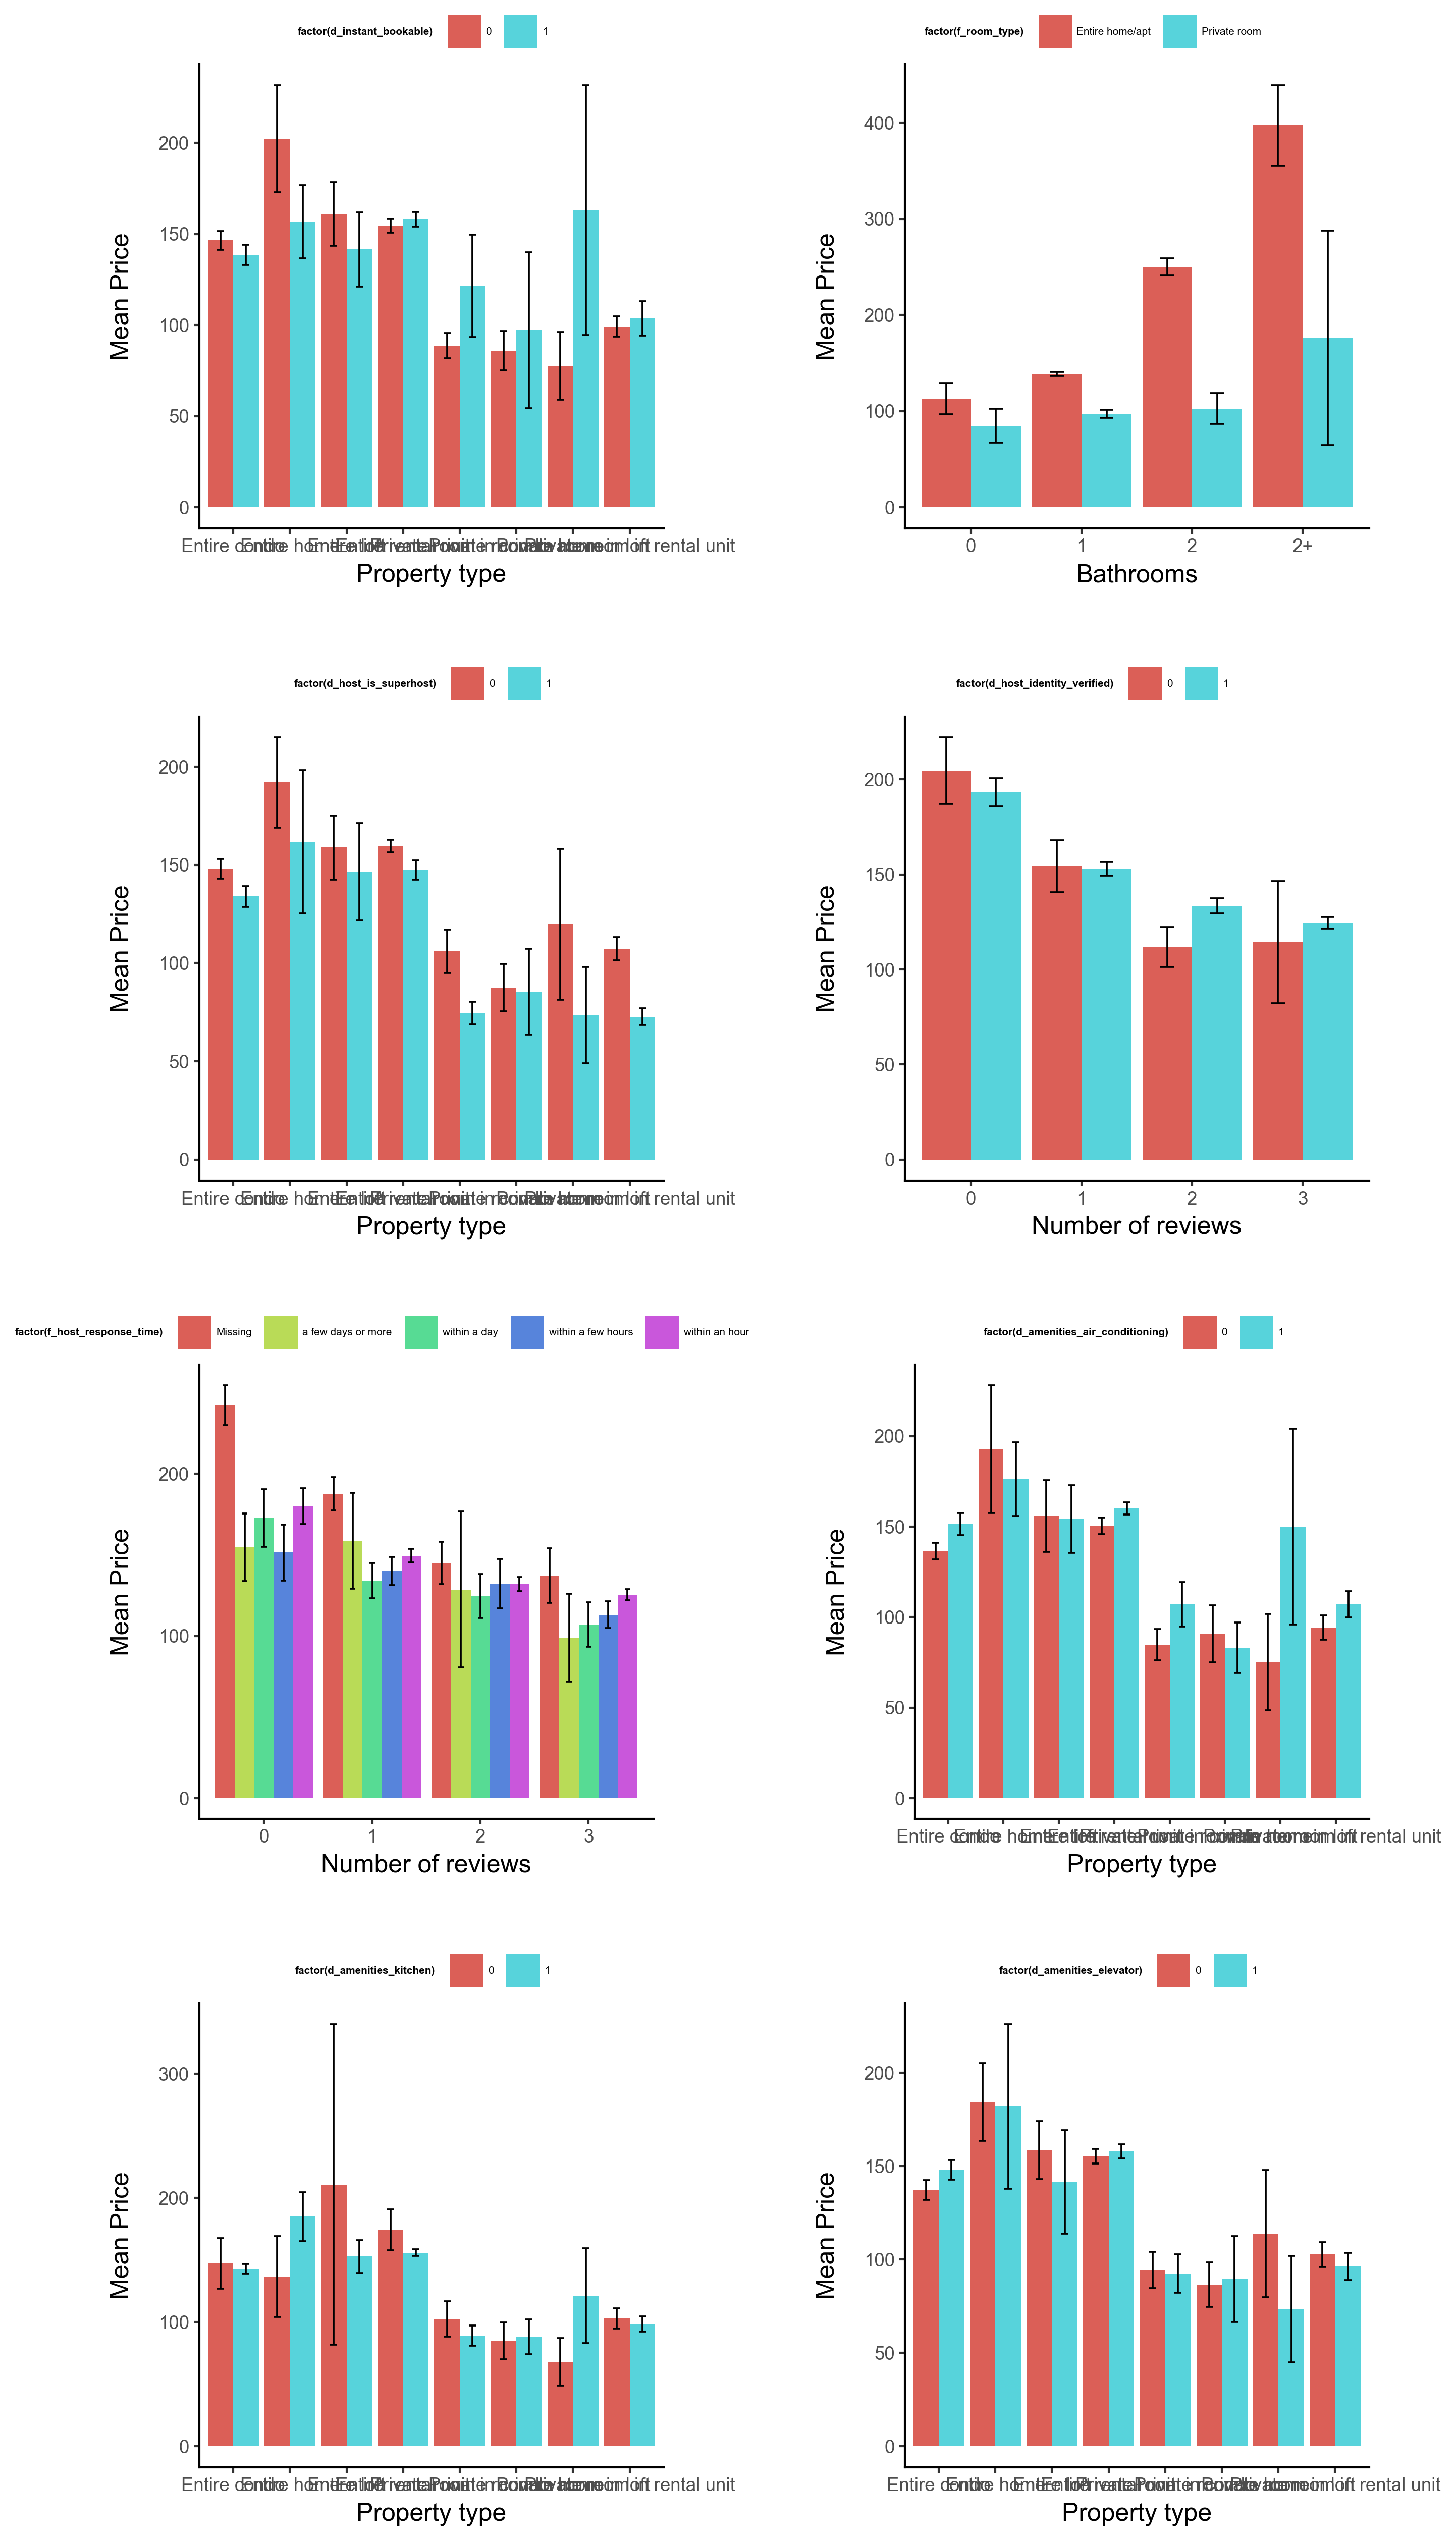

In [74]:
# interaction
p1 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_instant_bookable',
                        'Property type', 'Instant bookable')

# no interaction
p2 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_bathrooms', 'f_room_type',
                        'Bathrooms', 'Room type')

# no interaction
p3 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_host_is_superhost',
                        'Property type', 'Superhost')

# no interaction
p4 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_number_of_reviews', 'd_host_identity_verified',
                        'Number of reviews', 'Host identity verified')

# interaction
p5 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_number_of_reviews', 'f_host_response_time',
                        'Number of reviews', 'Host response time')

# interaction
p6 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_air_conditioning',
                        'Property type', 'A/C')

# interaction
p7 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_kitchen',
                        'Property type', 'Kitchen')

# no interaction
p8 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_elevator',
                        'Property type', 'Elevator')

g1 = pw.load_ggplot(p1, figsize=(3, 3))
g2 = pw.load_ggplot(p2, figsize=(3, 3))
g3 = pw.load_ggplot(p3, figsize=(3, 3))
g4 = pw.load_ggplot(p4, figsize=(3, 3))
g5 = pw.load_ggplot(p5, figsize=(3, 3))
g6 = pw.load_ggplot(p6, figsize=(3, 3))
g7 = pw.load_ggplot(p7, figsize=(3, 3))
g8 = pw.load_ggplot(p8, figsize=(3, 3))

interactions = (g1 | g2) / (g3 | g4 ) / (g5 | g6) / (g7 | g8)

display(interactions)

In [119]:
interaction_vars = ('f_property_type*d_instant_bookable', 'f_number_of_reviews*f_host_response_time',
                   'f_property_type*d_amenities_air_conditioning', 'f_property_type*d_amenities_kitchen')

In [121]:
ols_equations = [
    "~" + " + ".join(basic_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities + interaction_vars),
    ("~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities + interaction_vars) 
     + " + " + "(f_property_type + f_room_type + f_number_of_reviews) * (" + "+".join(amenities) + ")")
]

In [144]:
cv_list = []
for model in ols_equations:
    cv_list += [ols_crossvalidator("eur_price" + model, data_train, 5)]

14.8 s ± 390 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [124]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE
0,M1,16,0.17,177410,113.69,113.83
1,M2,39,0.24,176451,109.10,109.58
2,M3,55,0.26,176116,107.25,108.14
3,M4,98,0.27,176337,106.50,107.70
4,M5,131,0.28,176547,106.08,107.64
5,M6,532,0.30,179871,103.85,109.38


In [152]:
y, X = dmatrices("eur_price" + ols_equations[3], data_train)
ols_model = LinearRegression().fit(X, y)

In [187]:
y_hat = ols_model.predict(X)
ols_rmse = mean_squared_error(y, y_hat, squared=False)
ols_rmse

106.61195521017012

In [190]:
pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

,ols_coefficient
Intercept,-139907.619
f_property_type[T.Entire home],26.798
f_property_type[T.Entire loft],12.550
f_property_type[T.Entire rental unit],7.291
f_property_type[T.Private room in condo],-2.231
...,...
d_amenities_wine_glasses,7.256
d_amenities_cleaning_products,-1.723
d_amenities_coffee,3.419
d_amenities_self_check_in,-5.607


In [173]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0,
)
y, X = dmatrices("eur_price" + ols_equations[3], data_train)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso_model_cv.fit(X_scaled, y.ravel())

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                                   0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
                                   0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21,
                                   0.22, 0.23, 0.24, 0.25]},
             scoring='neg_root_mean_squared_error')

In [176]:
lasso_rmse = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha]
    .mean_test_score.values[0]
    * -1
)
lasso_rmse

107.61170923847742

In [183]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_property_type[T.Entire home],3.324
f_property_type[T.Entire loft],1.727
f_property_type[T.Entire rental unit],3.076
f_property_type[T.Private room in home],-0.851
f_property_type[T.Private room in loft],0.752
...,...
d_amenities_wine_glasses,3.556
d_amenities_cleaning_products,-0.868
d_amenities_coffee,1.646
d_amenities_self_check_in,-2.657


In [45]:
y, X = dmatrices("eur_price ~ " + " + ".join(predictors_ml), data_train)

In [33]:
cart_model = DecisionTreeClassifier(random_state=1234, criterion="gini")
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities
cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha": list(ccp_alphas)},
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 0,
    n_jobs = 1
)
cart_model_cv.fit(X, y.ravel())
cart_rmse = (
    pd.DataFrame(cart_model_cv.cv_results_)
    .loc[lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha]
    .mean_test_score.values[0]
    * -1
)
cart_rmse

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ccp_alpha=0.00010683019013459842;, score=-137.542 total time=   1.5s
[CV 2/5] END ccp_alpha=0.00010683019013459842;, score=-136.747 total time=   1.5s
[CV 3/5] END ccp_alpha=0.00010683019013459842;, score=-139.244 total time=   1.6s
[CV 4/5] END ccp_alpha=0.00010683019013459842;, score=-144.417 total time=   1.6s
[CV 5/5] END ccp_alpha=0.00010683019013459842;, score=-132.346 total time=   1.5s
[CV 1/5] END ccp_alpha=0.00011107254425546682;, score=-137.493 total time=   1.5s
[CV 2/5] END ccp_alpha=0.00011107254425546682;, score=-136.724 total time=   1.5s
[CV 3/5] END ccp_alpha=0.00011107254425546682;, score=-139.422 total time=   1.6s
[CV 4/5] END ccp_alpha=0.00011107254425546682;, score=-144.369 total time=   1.5s
[CV 5/5] END ccp_alpha=0.00011107254425546682;, score=-132.088 total time=   1.6s
[CV 1/5] END ccp_alpha=0.0001041305102395002;, score=-137.947 total time=   1.5s
[CV 2/5] END ccp_alpha=0.0001041305102

138.01927761137395

In [192]:
len(predictors_ml)

70

In [194]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=250,
    oob_score=True,
    n_jobs=7,
)

tune_grid = {"max_features": [5, 7, 9, 11], "min_samples_split": [5, 10, 20]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0
)

y, X = dmatrices("eur_price ~ " + " + ".join(predictors_ml), data_train)

rf_model_1 = rf_random.fit(X, y.ravel())


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=5, min_samples_split=5;, score=-105.169 total time=   1.2s
[CV 2/5] END max_features=5, min_samples_split=5;, score=-109.389 total time=   1.2s
[CV 3/5] END max_features=5, min_samples_split=5;, score=-100.035 total time=   1.2s
[CV 4/5] END max_features=5, min_samples_split=5;, score=-106.554 total time=   1.2s
[CV 5/5] END max_features=5, min_samples_split=5;, score=-106.136 total time=   1.1s
[CV 1/5] END max_features=5, min_samples_split=10;, score=-105.803 total time=   1.4s
[CV 2/5] END max_features=5, min_samples_split=10;, score=-110.759 total time=   1.0s
[CV 3/5] END max_features=5, min_samples_split=10;, score=-100.687 total time=   1.0s
[CV 4/5] END max_features=5, min_samples_split=10;, score=-107.642 total time=   1.1s
[CV 5/5] END max_features=5, min_samples_split=10;, score=-106.756 total time=   1.1s
[CV 1/5] END max_features=5, min_samples_split=20;, score=-106.978 total time=   0.9

In [196]:
rf_model_1.cv_results_["mean_test_score"].min()*-1

107.32748782283552

In [199]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=10, n_jobs=-1
)

In [201]:
categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [217]:
gbm_pipe.fit(data_train[list(predictors_ml)], data_train.eur_price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=12.7min


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [1, 5, 10],
                                          'n_estimators': [200, 250, 300, 350,
                                                           400, 450]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [219]:
gbm_model_cv.cv_results_["mean_test_score"].min()*-1

108.03756408037063

In [231]:
# Define XGBoost model with initial parameters
xgb = XGBRegressor(
    learning_rate=0.1, 
    min_child_weight=20, 
    tree_method="hist", 
    objective="reg:squarederror"
)

# Define hyperparameter tuning grid
tune_grid = {
    "n_estimators": [200, 300, 400, 500], 
    "max_depth": [1, 5, 10], 
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_model_cv = GridSearchCV(
    xgb, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=10, n_jobs=-1
)

# Split categorical and numerical predictors
categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]

# Define preprocessing (OneHotEncoder for categorical, passthrough for numerical)
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

# Define pipeline
xgb_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", xgb_model_cv)], verbose=True
)

# Train the model
xgb_pipe.fit(data_train[list(predictors_ml)], data_train.eur_price)


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 1.2min


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=20,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                                          'max_depth': [1, 5, 10],
                                          'n_estimators': [200, 300, 400, 500]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [233]:
xgb_model_cv.cv_results_["mean_test_score"].min()*-1

108.0315454749709